In [80]:
import sys,os
REPO_ROOT_DIR="../"
sys.path.append(os.path.dirname(REPO_ROOT_DIR))


In [47]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'  # Força o TensorFlow a usar apenas a CPU


In [48]:
%load_ext autoreload
%autoreload 2

import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import tsgm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
from src.raw_data.standartized_balanced import StandardizedViewDataset
data_folder = "data/standardized_view"
svd = StandardizedViewDataset(data_folder=data_folder)
# Carrega um dataset específico e retorna o DataFrame com dados do acelerômetro
df_MotionSense = svd.load_dataset("MotionSense", sensors=['accel',"gyro"])
print(df_MotionSense.shape)
y_train = df_MotionSense['standard activity code']
x_train = df_MotionSense.drop(columns=['standard activity code'])

(3558, 361)


In [50]:
y_train.shape

(3558,)

In [51]:
X_train_reshaped = x_train.values.reshape(x_train.shape[0], 60, 6)
X_train_reshaped.shape

(3558, 60, 6)

tsgm.utils.visualize_ts_lineplot(X_train_reshaped, y_train) 

In [52]:
scaler = tsgm.utils.TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(X_train_reshaped)

In [53]:
seq_len = 60
#X, y_i = tsgm.utils.gen_sine_vs_const_dataset(5_000, seq_len, 1, max_value=20, const=10)
#X.shape,y_i.shape

In [54]:
scaled_data.shape,y_train.shape

((3558, 60, 6), (3558,))

In [55]:
print(np.max(y_train))


5


In [56]:
y = keras.utils.to_categorical(y_train, num_classes=6)


In [57]:
import numpy as np 
X_train = scaled_data.astype(np.float32)
y = y.astype(np.float32)

In [58]:
latent_dim = 60
output_dim = 6
feature_dim = 6
seq_len = 60
batch_size = 128

In [59]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

In [60]:
architecture = tsgm.models.architectures.zoo["cgan_base_c4_l1"](
    seq_len=seq_len, feat_dim=feature_dim,
    latent_dim=latent_dim, output_dim=output_dim)
discriminator, generator = architecture.discriminator, architecture.generator

In [62]:
cond_gan = tsgm.models.cgan.ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

import matplotlib.pyplot as plt

def generate_latent_vector(latent_dim, batch_size):
    # Ajuste o latent_dim para corresponder ao esperado pelo gerador
    return np.random.normal(0, 1, (batch_size, latent_dim))



class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_samples, latent_dim, save_path):
        self.num_samples = num_samples
        self.latent_dim = latent_dim
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 10 == 0:
            # Ajuste o tamanho do vetor latente aqui
            noise = generate_latent_vector(self.latent_dim, self.num_samples)
            generated_samples = self.model.generator.predict(noise)
            # Salvar ou visualizar os samples gerados
            plt.figure(figsize=(10, 10))
            for i in range(self.num_samples):
                plt.subplot(1, self.num_samples, i + 1)
                plt.imshow(generated_samples[i], cmap='gray')
                plt.axis('off')
            plt.savefig(f'{self.save_path}/epoch_{epoch + 1}.png')
            plt.close()


#an_monitor = GANMonitor(num_samples=3, latent_dim=latent_dim, save_path="/tmp")

cbk = tsgm.models.monitors.GANMonitor(num_samples=3, latent_dim=latent_dim, save=True, labels=y, save_path="tmp")
cond_gan.fit(dataset, epochs=28)

Epoch 1/28
28/28 [==============================] - 6s 66ms/step - g_loss: 0.6916 - d_loss: 0.6970
Epoch 2/28
28/28 [==============================] - 2s 66ms/step - g_loss: 0.6849 - d_loss: 0.6953
Epoch 3/28
28/28 [==============================] - 2s 65ms/step - g_loss: 0.6974 - d_loss: 0.6946
Epoch 4/28
28/28 [==============================] - 2s 66ms/step - g_loss: 0.6908 - d_loss: 0.6941
Epoch 5/28
28/28 [==============================] - 2s 66ms/step - g_loss: 0.6983 - d_loss: 0.6944
Epoch 6/28
28/28 [==============================] - 2s 66ms/step - g_loss: 0.6938 - d_loss: 0.6939
Epoch 7/28
28/28 [==============================] - 2s 66ms/step - g_loss: 0.6920 - d_loss: 0.6940
Epoch 8/28
28/28 [==============================] - 2s 65ms/step - g_loss: 0.6964 - d_loss: 0.6941
Epoch 9/28
28/28 [==============================] - 2s 66ms/step - g_loss: 0.6937 - d_loss: 0.6938
Epoch 10/28
28/28 [==============================] - 2s 66ms/step - g_loss: 0.6864 - d_loss: 0.6935
Epoch 11/

In [63]:
limit = 500
X_gen = cond_gan.generate(y[:limit])
X_gen = X_gen.numpy()
y_gen = y[:limit]

In [64]:
X_train.shape

(3558, 60, 6)

In [82]:
import src.eval.visualization.line_plot

ModuleNotFoundError: No module named 'src.eval.visualization.line_plot'; 'src.eval.visualization' is not a package

In [75]:
visualize_ts_lineplot(X_train, y_train)


NameError: name 'visualize_ts_lineplot' is not defined

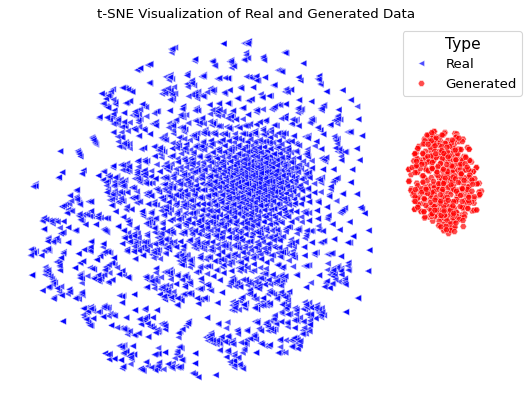

In [ ]:
X_train.shape
X_reshaped1 = X_train.reshape(X_train.shape[0], -1)
X_reshaped1.shape
X_gen_r=X_gen.reshape(X_gen.shape[0], -1)
print()

In [66]:

visualize_tsne(X_train[:limit], y[:limit], X_gen, y_gen)

NameError: name 'visualize_tsne' is not defined

In [ ]:
X_train.shape, y_train.shape

((3558, 60, 6), (3558,))

In [67]:
X_gen.shape, y_gen.shape

((500, 60, 6), (500, 6))

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def visualize_tsne(X, y, X_gen, y_gen, perplexity=30):
    from sklearn.manifold import TSNE
    
    # Convertendo one-hot para rótulos inteiros se necessário
    if y.ndim > 1:
        y = np.argmax(y, axis=1)
    if y_gen.ndim > 1:
        y_gen = np.argmax(y_gen, axis=1)

    # Aplicar TSNE
    tsne = TSNE(n_components=2, perplexity=perplexity)
    X_all = np.concatenate((X, X_gen), axis=0)
    X_emb = tsne.fit_transform(X_all)
    
    # Criar DataFrame para visualização
    df = pd.DataFrame(X_emb, columns=['TSNE1', 'TSNE2'])
    y_all = np.concatenate((y, y_gen), axis=0)
    df['Type'] = ['Real'] * len(y) + ['Generated'] * len(y_gen)
    df['Label'] = y_all

    # Definir paletas
    palette = sns.color_palette("hsv", len(np.unique(df['Label'])))
    
    # Plotar usando seaborn
    plt.figure(figsize=(8, 6), dpi=80)
    sns.scatterplot(
        data=df,
        x='TSNE1',
        y='TSNE2',
        hue='Type',
        style='Type',
        markers={"Real": "<", "Generated": "H"},
        palette=palette,
        alpha=0.7
    )
    
    plt.title('t-SNE Visualization')
    plt.show()

import numpy as np







In [69]:

# Converter de volta para rótulos inteiros
y_train_labels = np.argmax(y, axis=1)
y_gen_labels = np.argmax(y_gen, axis=1)

print("Rótulos reais:", y_train_labels.shape)
print("Rótulos gerados:", y_gen_labels.shape)



Rótulos reais: (3558,)
Rótulos gerados: (500,)


In [70]:
y_train_labels.shape,y_gen_labels.shape

((3558,), (500,))

In [71]:
visualize_ts_lineplot(X_gen, y_gen_labels,2
                      )
plt.savefig("synth_data_temporal_gan.pdf", bbox_inches='tight')

NameError: name 'visualize_ts_lineplot' is not defined

In [ ]:
def visualize_original_and_reconst_ts(
    original: tsgm.types.Tensor,
    reconst: tsgm.types.Tensor,
    num: int = 5,
    vmin: int = 0,
    vmax: int = 1,
) -> None:
    """
    Visualizes original and reconstructed time series data.

    This function generates side-by-side visualizations of the original and reconstructed time series data.
    It randomly selects a specified number of samples from the input tensors `original` and `reconst` and
    displays them as images using imshow.

    :param original: Original time series data tensor.
    :type original: tsgm.types.Tensor
    :param reconst: Reconstructed time series data tensor.
    :type reconst: tsgm.types.Tensor
    :param num: Number of samples to visualize, defaults to 5.
    :type num: int, optional
    :param vmin: Minimum value for colormap normalization, defaults to 0.
    :type vmin: int, optional
    :param vmax: Maximum value for colormap normalization, defaults to 1.
    :type vmax: int, optional
    """
    assert original.shape == reconst.shape

    fig, axs = plt.subplots(num, 2, figsize=(14, 10))

    ids = np.random.choice(original.shape[0], size=num, replace=False)
    for i, sample_id in enumerate(ids):
        axs[i, 0].imshow(original[sample_id].T, aspect="auto", vmin=vmin, vmax=vmax)
        axs[i, 1].imshow(reconst[sample_id].T, aspect="auto", vmin=vmin, vmax=vmax)


In [72]:
visualize_original_and_reconst_ts(X_train[0:500], X_gen, num=10)


NameError: name 'visualize_original_and_reconst_ts' is not defined

In [73]:
spec_entropy = tsgm.metrics.EntropyMetric()
print(spec_entropy(X_train))
print(spec_entropy(X_gen))

/HDD/dados/amparo/disciplinas/ger_ghar/GenHAR/projetos/GenHAR/venv_3.10_genHar/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 60, using nperseg = 60
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


18348.81216344693
2616.913231097886
